# CNN training example

This notebook illustrates how to use EDIT pipeline to train a simple CNN model on the ERA5 lowres dataset.

Make sure to set the `ERA5LOWRES` environment variable to make the ERA5 low-resolution archive foundable on your system.
Modify the following cell as follows:

- for NCI

```
%env ERA5LOWRES=/g/data/wb00/NCI-Weatherbench/5.625deg
```

- for NIWA

```
%env ERA5LOWRES=/nesi/nobackup/niwa00004/riom/weatherbench/5.625deg
```

In [1]:
%env ERA5LOWRES=/nesi/nobackup/niwa00004/riom/weatherbench/5.625deg

env: ERA5LOWRES=/nesi/nobackup/niwa00004/riom/weatherbench/5.625deg


In [2]:
import sys
from pathlib import Path

import numpy as np
import xarray as xr
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning import Trainer, LightningModule
from lightning.pytorch.callbacks import RichProgressBar

import edit.data
import edit.tutorial
import edit.pipeline
import edit.training

/scale_wlg_persistent/filesets/project/niwa99999/riom/edit_evaluation/EDIT/packages/data/src/edit/data/__init__.py:142: FutureWarning: `edit` is under heavy development and may not continue to be supported.
  __python_warnings.warn(


In [3]:
# train/test split dates
train_start = "2015-01-01T00"
train_end = "2015-01-12T00"
val_start = "2017-01-01T00"
val_end = "2017-01-12T00"

# number of samples to estimate mean & standard deviation of fields
n_samples = 200
# folder to save estimated mean & standard deviation of fields
stats_folder = "cnn_training/stats"

# folders used to cache dataset processed by the pipeline
cache_folder = "cnn_training/cache"

# data loader parameters
batch_size = 1
n_workers = 2

# trainer parameters
default_root_dir = "cnn_training"
max_epochs = 10

## Data preparation

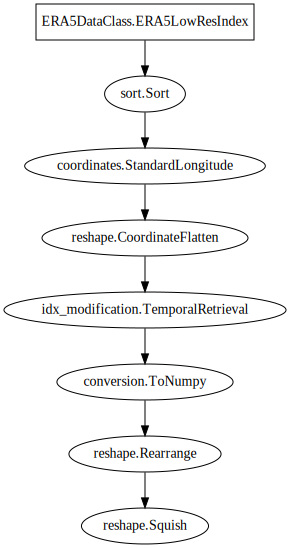

In [4]:
data_preparation = edit.pipeline.Pipeline(
    edit.data.archive.era5lowres(["u", "v", "geopotential", "vorticity"]),
    edit.pipeline.operations.xarray.Sort(
        ["msl", "10u", "10v", "2t", "geopotential", "vorticity"]
    ),
    edit.data.transforms.coordinates.standard_longitude(type="0-360"),
    edit.pipeline.operations.xarray.reshape.CoordinateFlatten("level"),
    # retrieve previous/next samples, dt = 1H
    edit.pipeline.modifications.TemporalRetrieval(
        concat=True, samples=((-1, 1), (1, 1, 1))
    ),
    edit.pipeline.operations.xarray.conversion.ToNumpy(),
    edit.pipeline.operations.numpy.reshape.Rearrange("c t h w -> t c h w"),
    edit.pipeline.operations.numpy.reshape.Squish(axis=0),
)
data_preparation

In [5]:
sample = data_preparation[train_start]
print(len(sample))
print(sample[0].shape)
print(sample[1].shape)

2
(52, 32, 64)
(52, 32, 64)


In [6]:
train_split = edit.pipeline.iterators.DateRange(train_start, train_end, interval="1h")
train_split = train_split.randomise(seed=42)
val_split = edit.pipeline.iterators.DateRange(val_start, val_end, interval="1h")

In [7]:
train_split[:5]

(EDITDatetime('2015-01-01T23'),
 EDITDatetime('2015-01-09T12'),
 EDITDatetime('2015-01-08T04'),
 EDITDatetime('2015-01-05T19'),
 EDITDatetime('2015-01-05T17'))

Let's precompute approximate mean and standard deviation using only few random samples, to rescale the input/output data to a reasonable range for model training.

In [8]:
#samples = np.stack([data_preparation[train_split[i]][0] for i in range(n_samples)])
#mean_approx = np.mean(samples, axis=0)
#std_approx = np.std(samples, axis=0)

stats_folder = Path(stats_folder)
#stats_folder.mkdir(parents=True, exist_ok=True)

mean_path = stats_folder / "mean.npy"
std_path = stats_folder / "std.npy"

#np.save(mean_path, mean_approx)
#np.save(std_path, std_approx)

In [9]:
normaliser = edit.pipeline.operations.numpy.normalisation.Deviation(
    mean=mean_path, deviation=std_path
)
caching_step = edit.pipeline.modifications.Cache(
    cache_folder, pattern_kwargs={'extension': 'npy'}
)
data_preparation_normed = edit.pipeline.Pipeline(
    data_preparation, normaliser, caching_step
)

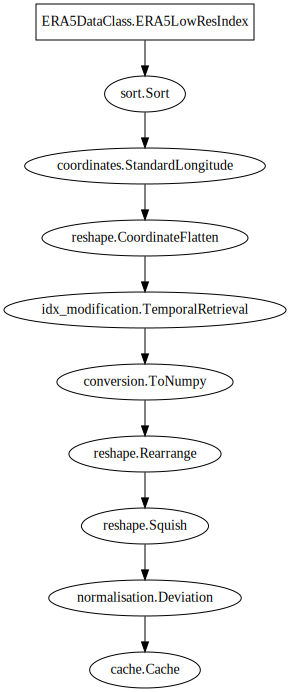

In [10]:
data_preparation_normed

## Model fitting

In [11]:
class CNN(LightningModule):
    def __init__(
        self,
        *,
        n_features: int,
        layer_sizes: list[int],
        dropout: float,
        learning_rate: float,
    ):
        super().__init__()

        layer_sizes = (n_features,) + tuple(layer_sizes)
        layers = []
        for chan_in, chan_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.extend(
                [
                    nn.Conv2d(chan_in, chan_out, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(),
                    nn.Dropout(p=dropout),
                ]
            )
        layers.append(
            nn.Conv2d(layer_sizes[-1], n_features, kernel_size=3, stride=1, padding=1)
        )
        self.cnn = nn.Sequential(*layers)

        self.learning_rate = learning_rate
        self.loss_function = F.l1_loss

    def forward(self, x):
        return self.cnn(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, targets)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {"optimizer": optimizer}

In [12]:
n_features = data_preparation_normed[train_start][0].shape[-3]
model = CNN(
    n_features=n_features, layer_sizes=[64, 64], dropout=0.6, learning_rate=1e-5
)

In [13]:
model

CNN(
  (cnn): Sequential(
    (0): Conv2d(52, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Conv2d(64, 52, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [14]:
# ensures that we use CPU if a GPU is available, uncomment to use your GPU
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


**Note:** Here we use `forkserver` to prevent deadlocks on Linux platform when using more than one worker in the data loader.

In [15]:
data_module = edit.training.data.lightning.PipelineLightningDataModule(
    data_preparation_normed,
    train_split=train_split,
    valid_split=val_split,
    batch_size=batch_size,
    num_workers=n_workers,
    multiprocessing_context="forkserver",
    persistent_workers=True,
)

In [16]:
data_module

PipelineLightningDataModule
	Initialisation                 Pytorch Lightning DataModule.
		 batch_size                     1
		 iterator_dataset               False
		 multiprocessing_context        'forkserver'
		 num_workers                    2
		 persistent_workers             True
		 pipelines                      {'Pipeline': {'__args': '(Pipeline\n\tDescription                    `edit.pipeline` Data Pipeline\n\n\n\tInitialisation                 \n\t\t exceptions_to_ignore           None\n\t\t iterator                       None\n\t\t sampler                        None\n\tSteps                          \n\t\t ERA5DataClass.ERA5LowResIndex  {\'ERA5LowResIndex\': {\'level_value\': \'None\', \'variables\': "[\'u\', \'v\', \'geopotential\', \'vorticity\']"}}\n\t\t sort.Sort                      {\'Sort\': {\'order\': "[\'msl\', \'10u\', \'10v\', \'2t\', \'geopotential\', \'vorticity\']", \'safe\': \'False\'}}\n\t\t coordinates.StandardLongitude  {\'StandardLongitude\': {\'longitude_name\': "\'longitude\'", \'type\': "\'0-360\'"}}\n\t\t reshape.CoordinateFlatten      {\'CoordinateFlatten\': {\'__args\': \'()\', \'coordinate\': "\'level\'", \'skip_missing\': \'False\'}}\n\t\t idx_modification.TemporalRetrieval {\'TemporalRetrieval\': {\'concat\': \'True\', \'delta_unit\': \'None\', \'merge_function\': \'None\', \'merge_kwargs\': \'None\', \'samples\': \'((-1, 1), (1, 1, 1))\'}}\n\t\t conversion.ToNumpy             {\'ToNumpy\': {\'reference_dataset\': \'None\', \'run_parallel\': \'False\', \'saved_records\': \'None\', \'warn\': \'True\'}}\n\t\t reshape.Rearrange              {\'Rearrange\': {\'rearrange\': "\'c t h w -> t c h w\'", \'rearrange_kwargs\': \'None\', \'reverse_rearrange\': \'None\', \'skip\': \'False\'}}\n\t\t reshape.Squish                 {\'Squish\': {\'axis\': \'0\'}}, Deviation\n\tInitialisation                 Deviation Normalisation\n\t\t deviation                      PosixPath(\'cnn_training/stats/std.npy\')\n\t\t expand                         True\n\t\t mean                           PosixPath(\'cnn_training/stats/mean.npy\'), Cache\n\tInitialisation                 An `edit.pipeline` implementation of the `CachingIndex` from `edit.data`.\n\t\t cache                          \'/scale_wlg_persistent/filesets/project/niwa99999/riom/edit_evaluation/EDIT/packages/tutorial/nbook/cnn_training/cache\'\n\t\t cache_validity                 \'warn\'\n\t\t pattern                        None\n\t\t pattern_kwargs                 {\'extension\': "\'npy\'"}\n\t\t save_kwargs                    None)', 'exceptions_to_ignore': 'None', 'iterator': 'None', 'sampler': 'None'}}
		 train_split                    {'Randomise': {'iterator': {'DateRange': {'end': "'2015-01-12T00'", 'interval': "'1h'", 'start': "'2015-01-01T00'"}}, 'seed': '42'}}
		 valid_split                    {'DateRange': {'end': "'2017-01-12T00'", 'interval': "'1h'", 'start': "'2017-01-01T00'"}}

In [17]:
trainer = Trainer(
    default_root_dir=default_root_dir,
    max_epochs=max_epochs,
    callbacks=[RichProgressBar()]
)
trainer.fit(model, datamodule=data_module)

Epoch 9/9  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264/264 0:00:03 • 0:00:00 72.95it/s v_num: 31.000

`Trainer.fit` stopped: `max_epochs=10` reached.


## Predictions

## Evaluation